In [706]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [707]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [708]:
# data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [709]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

Using downloaded and verified file: /home/caesar/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/breastmnist.npz


In [710]:
print(train_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /home/caesar/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0


In [711]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

EMBEDDING_LEN = 16

# Load MNIST dataset
(x_train, y_train) = (train_dataset.imgs, train_dataset.labels)
(x_test, y_test) = (test_dataset.imgs, test_dataset.labels)

In [712]:
print(x_train.shape)
print(y_train.shape)

(546, 28, 28)
(546, 1)


In [713]:
# Preprocess images
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Get the user-specified embedding length
embedding_length = EMBEDDING_LEN

# Define a CNN model with variable embedding length
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(embedding_length, activation='relu'),  # Embedding layer with variable length
# ])  # Remove the final classification layer

model = Sequential([
    # Initial convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Second convolutional block for deeper feature extraction
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten and dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(embedding_length, activation='relu')  # Variable-length embedding layer
])

In [714]:
# Compile the model (important for generating meaningful embeddings)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [715]:
# Extract embeddings for all images in the training set
embeddings_train = model.predict(x_train)
print(embeddings_train.shape)  # Output: (60000, embedding_length)

18/18 [==============================] - 0s 7ms/step
(546, 16)


In [716]:
# Optionally, extract embeddings for test images
embeddings_test = model.predict(x_test)
print(embeddings_test.shape)  # Output: (10000, embedding_length)

5/5 [==============================] - 0s 7ms/step
(156, 16)


In [717]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
#(, y_train), (x_test, y_test)

(546, 28, 28, 1)
(546, 1)
(156, 28, 28, 1)
(156, 1)


In [718]:
import numpy as np
from sklearn.svm import SVC

In [719]:
# Load your dataset (assuming it's in NumPy arrays)
x_train = embeddings_train
y_train = y_train
x_test = embeddings_test
y_test = y_test

In [720]:
# Create an SVM classifier with a suitable kernel
clf = SVC(kernel='rbf', C=1.0, gamma='scale')  # RBF kernel often works well

In [721]:
# Fit the classifier on the training data
y_train = y_train.ravel()
clf.fit(x_train, y_train)

SVC()

In [722]:
# Make predictions on the test data
y_pred = clf.predict(x_test)

In [723]:
# Evaluate model performance
y_test = y_test.ravel()
accuracy = clf.score(x_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.7948717948717948


              precision    recall  f1-score   support

           0       0.86      0.29      0.43        42
           1       0.79      0.98      0.88       114

    accuracy                           0.79       156
   macro avg       0.82      0.63      0.65       156
weighted avg       0.81      0.79      0.75       156



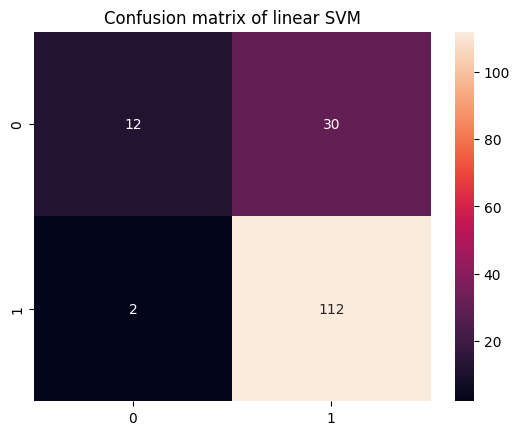

In [724]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.26      0.38       147
           1       0.78      0.96      0.86       399

    accuracy                           0.77       546
   macro avg       0.73      0.61      0.62       546
weighted avg       0.75      0.77      0.73       546



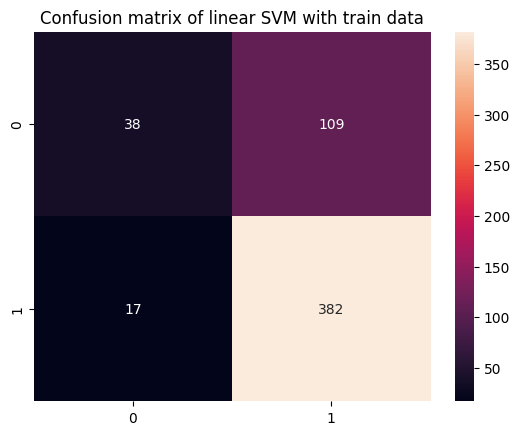

In [727]:
y_pred_train = clf.predict(x_train)

cm_train = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d').set_title('Confusion matrix of linear SVM with train data')

print(classification_report(y_train,y_pred_train))

In [729]:
clf.get_params()
print(clf.n_support_)

[145 154]


In [732]:
# get the actual output of SVM
decision_function = clf.decision_function(x_test)
print(decision_function)

[-0.3900645   0.80630885  1.02181894  0.59796559  1.05688711  1.01430595
 -0.73524444  0.53809113  0.96996989  0.93714013  0.84823199 -0.6353894
  0.30059443  0.39461706  0.90938349  1.07128239  1.08751203  1.12168135
  1.23852762  0.22739734  0.2370772   0.99190803  1.17932579  0.28305878
  0.52082989  0.05645932  0.88808596  1.24061077  1.20178522  1.01027988
  0.89594034  1.12293873  1.30546215  1.14983572  1.01277353  0.96493147
  0.92575186  1.04481566 -0.1067225   0.9393787   1.22447657  0.27342746
  1.05295306  1.0652414   1.06589399  0.69776537  1.13208036  0.9932497
  0.98296556  1.00439059  0.89618158  1.0544884   0.93025436  1.03728591
  1.01730753 -0.67570286  1.1528981   0.97323115 -0.22510378  1.00892375
  0.50906448  1.00403329  1.13658018  0.48027235  1.23341094  0.67724084
  1.20894153  0.53102011  1.1135815   0.91299901  1.15080805  1.1662837
  1.16359752  1.28000446  1.0064924   0.86437397 -0.90780619  0.67165139
  0.62116391  1.18421218  1.02898713  0.21448288  0.99

In [751]:
import numpy as np
print("svc.gamma: ", clf.gamma)
print("svc.degree: ", clf.degree)

sv=open("../data-kernel-model-rbf/support_vectors_rbf.txt","w")
dual_coeff=open("../data-kernel-model-rbf/dual_coeff_rbf.txt","w")
intercept=open("../data-kernel-model-rbf/intercept_rbf.txt","w")
xtestSample="../data-kernel-model-rbf/xtest_rbf.txt"
ytestSample="../data-kernel-model-rbf/ytest_rbf.txt"
ytestClassificationScore="../data-kernel-model-rbf/yclassificationscore.txt"

np.savetxt(sv,clf.support_vectors_)
    
np.savetxt(dual_coeff,clf.dual_coef_,delimiter=' ')
np.savetxt(intercept,clf.intercept_,delimiter=' ')

with open(xtestSample, "w") as f1:
    for item in x_test[0]:  # Access the first row directly
        f1.write(str(item) + " ")
        
with open(ytestClassificationScore, "w") as f2:
    f2.write(str(decision_function[0]))
    
with open(ytestSample, "w") as f3:
    f3.write(str(y_test[0]))
    
sv.close()
dual_coeff.close()
intercept.close()
f1.close()
f2.close()
f3.close()

svc.gamma:  scale
svc.degree:  3
